In [1]:
from snowflake.snowpark import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.functions import col
from snowflake.snowpark import types as T
from snowflake.snowpark.types import *
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import numpy as np
import random
import matplotlib.pyplot as plt
import itertools
from snowflake.ml.utils.connection_params import SnowflakeLoginOptions

# from utilities_time_series import establish_hourly_time_series, create_hourly_df, create_daily_df
from utilities_time_series import generate_time_series_data, create_dataframe

## Create session

In [2]:
session = Session.builder.configs(SnowflakeLoginOptions()).getOrCreate()

SnowflakeLoginOptions() is in private preview since 0.2.0. Do not use it in production. 


## Create schema

In [3]:
session.sql("CREATE SCHEMA IF NOT EXISTS MOCKSERIES").collect()

[Row(status='Schema MOCKSERIES successfully created.')]

## Change context

In [4]:
session.use_schema("MOCKSERIES")
print(f'db.schema: {session.get_fully_qualified_current_schema()}')

db.schema: "CROMANO"."MOCKSERIES"


## User-Defined Parameters

In [5]:
# ==================================================================================================
# ESTABLISH WHAT PARTITIONS WILL BE USED (IF ANY)
# ==================================================================================================
# NOTE: CHANGE to specify zero, one, or multiple partition columns to match their use case

# List of all partition column names followed by a list of the number of unique values for each corresponding partition column
#partition_columns = ['STORE_ID', 'PRODUCT_ID'] 
partition_columns = ['STORE_ID']         
unique_value_counts = [5000] # Multiply all the values in the list to get the total number or partitions in the data set                     


# ==================================================================================================
# ESTABLISH WHAT EXOGENOUS FEATURES YOU MIGHT WANT TO INCLUDE (IF ANY)
# ==================================================================================================
# NOTE: CHANGE to specify zero, one, or multiple exogenous features to match their use case

exogenous_feature_columns = ['FEATURE_1', 'FEATURE_2']
stddev_scale_factors = [2.5, 10.0] # LOWER numbers will make features that are MORE correlated with the TARGET                    


# ==================================================================================================
# SET START YEAR & GRAULARITY (daily, hourly, or weekly). 
# ==================================================================================================

# Specify granularity. Example: 'hourly' will generate a time series value at each hour
granularity = 'daily'

# Specifying the start year will make the first data point occur on January 1st of that year
start_year = 2021                


# ==================================================================================================
# PARAMETER RANGES FOR TIME SERIES FUNCTION
# ==================================================================================================
# NOTE: CHANGE these ranges to adjust qualities of the time series such as trend and seasonality

# Ranges for random generation of parameter values  
trend_coeff_range = (-0.75, 0.75)
trend_flat_base_range = (50, 900)
seasonality_daily_amp_range = (2, 15)
seasonality_weekly_amp_range = (2, 25)
seasonality_6mo_amp_range = (15, 40)
seasonality_yearly_amp_range = (15, 50)
noise_mean_range = (0, 0)
noise_std_range = (1, 15)
noise_corr_range = (0.25, 0.65)

## Create separate time series for each of many partitions

In [6]:
# Create a list of lists, where each list is the unique values for the partition column at the corresponding index. 
value_lists = []
for i in unique_value_counts:
    value_lists.append(list(range(1,i+1)))

# Create a list of all possible partition value combinations
all_combos = list(itertools.product(*value_lists))
number_of_partitions = len(all_combos)
print(f"Number of partitions: {number_of_partitions}")

# List to hold each partition's pandas DataFrame
df_list = []

# Loop through partitions and create time series for each partition
for combo in all_combos:
    time_points, ts_values = generate_time_series_data(
        start_year = start_year,
        grain = granularity,
        trend_coeff = random.uniform(*trend_coeff_range),
        trend_flat_base = random.randint(*trend_flat_base_range),
        seasonality_daily_amp = random.randint(*seasonality_daily_amp_range),
        seasonality_weekly_amp = random.randint(*seasonality_weekly_amp_range),
        seasonality_6mo_amp = random.randint(*seasonality_6mo_amp_range),
        seasonality_yearly_amp = random.randint(*seasonality_yearly_amp_range),
        noise_mean = random.randint(*noise_mean_range),
        noise_std = random.randint(*noise_std_range),
        noise_corr = random.uniform(*noise_corr_range)
        ) 
    
    df_single_partition = create_dataframe(time_points, ts_values)


    # Add the partition columns to the DataFrame
    if partition_columns:
        for i in range(len(partition_columns)):
            df_single_partition[partition_columns[i]] = combo[i]

    # Add exogenous features that are correlated with the target
    if exogenous_feature_columns:
        target_stddev_hourly = df_single_partition['TARGET'].std()

        for i in range(len(exogenous_feature_columns)):
            df_single_partition[exogenous_feature_columns[i]] = (
                df_single_partition['TARGET'] + 
                np.random.normal(loc=0, scale=stddev_scale_factors[i] * target_stddev_hourly, size=len(df_single_partition)) 
                )

    # Append the partition's DataFrame to the list
    df_list.append(df_single_partition)

# # Combine all partition DataFrames into a single DataFrame
df_all = pd.concat(df_list, ignore_index=True)

# NOTE: 50,000 partitions took 4.5 minutes to generate and combine into a single DataFrame

Number of partitions: 5000


In [7]:
# Look at df
df_all.head(2)

,ORDER_TIMESTAMP,TARGET,STORE_ID,FEATURE_1,FEATURE_2
0,2021-01-01,473.122066,1,509.961817,214.203431
1,2021-01-02,489.535994,1,430.356716,697.048037


In [8]:
# Display correlation coefficients between exogenous features and target
print("CORRELATION COEFFICIENT WITH TARGET \n")
for col in exogenous_feature_columns:
    print(f"{col}: {round(df_all['TARGET'].corr(df_all[col]), 3)}")

CORRELATION COEFFICIENT WITH TARGET 

FEATURE_1: 0.886
FEATURE_2: 0.432


## Create Snowpark DataFrames 

In [9]:
sdf = session.create_dataframe(df_all)

# NOTE: The pandas df with 50,000 partitions took 18 minutes to turn into a Snowpark df

In [10]:
sdf.describe().to_pandas()

,SUMMARY,TARGET,STORE_ID,FEATURE_1,FEATURE_2
0,max,1.181985e+03,5.000000e+03,1.778338e+03,4.761904e+03
1,min,-2.165765e+02,1.000000e+00,-8.950646e+02,-3.897128e+03
2,count,6.745000e+06,6.745000e+06,6.745000e+06,6.745000e+06
3,stddev,2.589538e+02,1.443376e+03,2.922130e+02,6.000511e+02
4,mean,4.760254e+02,2.500500e+03,4.760525e+02,4.762004e+02


## Write tables to snowflake

In [11]:
sdf.write.save_as_table(f"{granularity.upper()}_TS_{number_of_partitions}_PARTITIONS_STARTING_{start_year}", mode="overwrite")
print(f"Created Table: {granularity.upper()}_TS_{number_of_partitions}_PARTITIONS_STARTING_{start_year}")

Created Table: DAILY_TS_5000_PARTITIONS_STARTING_2021


___

# EXPLORATION

Visualize result of above code

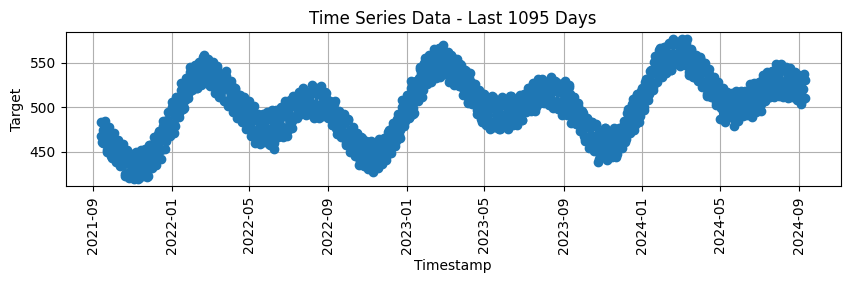

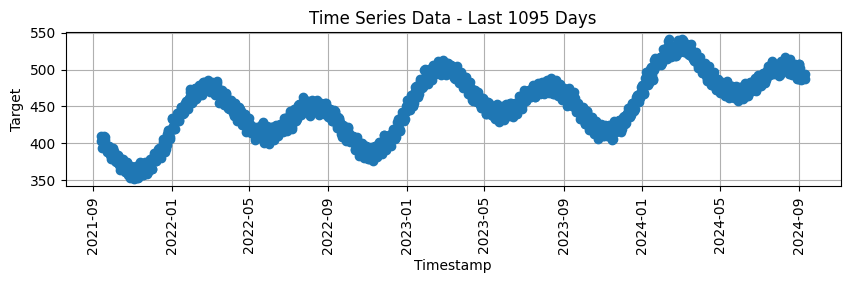

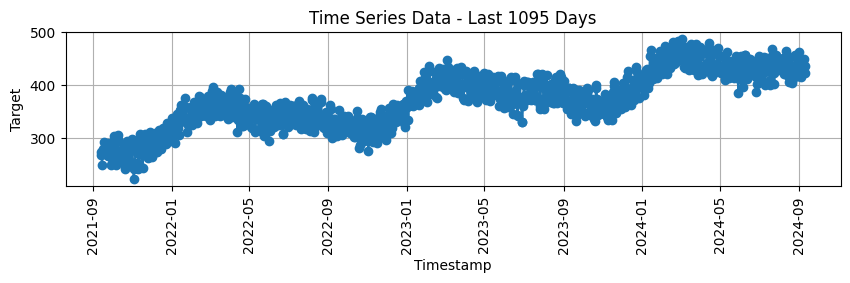

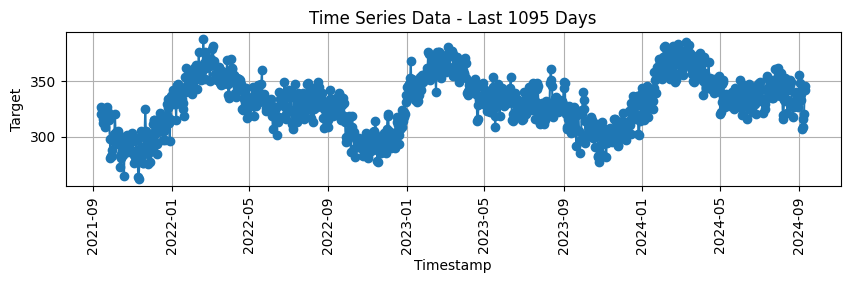

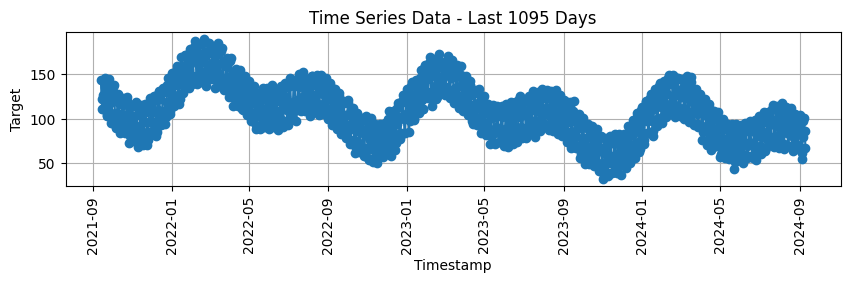

In [12]:
# EXPLORE: Look at plots for different partitions
for combo in all_combos[:5]:
    source_df = df_all
    x = 1095

    #df = source_df.loc[(source_df['STORE_ID']==combo[0]) & (source_df['PRODUCT_ID']==combo[1])].copy()
    df = source_df.loc[(source_df['STORE_ID']==combo[0])].copy()
    df.set_index('ORDER_TIMESTAMP', inplace=True)

    recent_x_months = df.loc[df.index >= pd.Timestamp.now() - pd.DateOffset(days=x)]

    plt.figure(figsize=(10, 2))
    plt.plot(recent_x_months.index, recent_x_months['TARGET'], marker='o', linestyle='-')
    plt.xlabel('Timestamp')
    plt.ylabel('Target')
    plt.title(f'Time Series Data - Last {x} Days')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()

Create a calendar table

In [13]:
def create_date_table(start='2018-01-01', end='2025-12-31'):
    df = pd.DataFrame({"CALENDAR_DATE": pd.date_range(start, end)})
    df["CALENDAR_WEEK_DAY_NBR"] = df.CALENDAR_DATE.dt.dayofweek
    df["CALENDAR_MTH_DAY_NBR"] = df.CALENDAR_DATE.dt.day
    df["CALENDAR_MTH"] = df.CALENDAR_DATE.dt.month
    df["CALENDAR_YEAR"] = df.CALENDAR_DATE.dt.year
    return df

calendar_df = create_date_table()

In [14]:
calendar = USFederalHolidayCalendar()
holiday_df = (
    pd.DataFrame(
        calendar.holidays(start='2018-01-01', end='2025-12-31', return_name=True)
    )
    .reset_index()
    .rename(columns={"index": "date", 0: "holiday_name"})
)

In [15]:
holiday_df['date'] = holiday_df['date'].dt.date
calendar_df['CALENDAR_DATE'] = calendar_df['CALENDAR_DATE'].dt.date
calendar_final = calendar_df.merge(holiday_df, left_on='CALENDAR_DATE', right_on='date', how = 'left')

In [16]:
calendar_final = calendar_final.rename(columns={"holiday_name":"HOLIDAY_NAME"})
calendar_final_snow_df = session.create_dataframe(calendar_final).select('CALENDAR_DATE','CALENDAR_WEEK_DAY_NBR','CALENDAR_MTH_DAY_NBR','CALENDAR_MTH','CALENDAR_YEAR','HOLIDAY_NAME')

In [18]:
calendar_final_snow_df = calendar_final_snow_df.\
select(F.col('CALENDAR_DATE'),\
       F.col('CALENDAR_WEEK_DAY_NBR').cast(StringType()).alias('WEEK_DAY_NBR'),\
       F.col('CALENDAR_MTH_DAY_NBR').cast(StringType()).alias('MTH_DAY_NBR'),\
       F.col('CALENDAR_MTH').cast(StringType()).alias('CALENDAR_MTH'),\
       F.col('CALENDAR_YEAR').cast(StringType()).alias('CALENDAR_YEAR'),\
       F.col('HOLIDAY_NAME'))

In [19]:
calendar_final_snow_df.show()

--------------------------------------------------------------------------------------------------------
|"CALENDAR_DATE"  |"WEEK_DAY_NBR"  |"MTH_DAY_NBR"  |"CALENDAR_MTH"  |"CALENDAR_YEAR"  |"HOLIDAY_NAME"  |
--------------------------------------------------------------------------------------------------------
|2018-01-01       |0               |1              |1               |2018             |New Year's Day  |
|2018-01-02       |1               |2              |1               |2018             |NULL            |
|2018-01-03       |2               |3              |1               |2018             |NULL            |
|2018-01-04       |3               |4              |1               |2018             |NULL            |
|2018-01-05       |4               |5              |1               |2018             |NULL            |
|2018-01-06       |5               |6              |1               |2018             |NULL            |
|2018-01-07       |6               |7              |1  

In [20]:
calendar_final_snow_df.write.saveAsTable('cromano.mockseries.CALENDAR_INFO_2018', mode='overwrite', create_temp_table=False)